In [29]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import re
import shutil, os
import json
import glob,copy
from collections import OrderedDict



def exel2df(exel_path, root_clas, root, save_foldername):
    
    df = pd.read_excel(exel_path)
    df_new = df[df['label']==root_clas]
    df_new = df_new.reset_index(drop=True)
    print('number of images = ',len(df_new))
    
    return df_new




def visualize_GT_bbox(df_new, num_to_show, root):
    
    for i in range(num_to_show):
        filename = df_new.loc[i]['idx_cvg']
        img = cv2.imread(root+str(filename)+'.jpg')
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        string = df_new.loc[i]['custom_roi']
        numbers = re.findall(r'\d+', string)
        for j in range(int(len(numbers)/4)):
            x1 = int(numbers[j*4 + 0])
            y1 = int(numbers[j*4 + 1])
            x2 = int(numbers[j*4 + 2])
            y2 = int(numbers[j*4 + 3])

            cv2.rectangle(img2, (x1,y1),(x2,y2), (255,255,0), 3)

        plt.figure(figsize=(10,10))
        plt.imshow(img2)
        plt.axis('off')
        plt.show()
        
        
        
        
def filecopy_maketxt(df_new, dataset_name, datasetname_path, test_ratio):

    print('======================================')
    print('dataset = ', dataset_name)
    print('======================================')
    
    # 폴더 없으면 만들기
    if os.path.isdir(datasetname_path)==False: 
        os.mkdir(datasetname_path)


    if dataset_name=='train2017':
        st_num, end_num = 0, int(len(df_new)*(1-test_ratio))
    else:
        st_num, end_num = int(len(df_new)*(1-test_ratio)), int(len(df_new))
        
        
    # train.txt, val.txt 생성
    # train2017/ , val2017/ 생성하여 이미지 복사
    
    f=open('./datasets/%s/%s.txt'%(foldername,dataset_name[:3]),'w')
    for i in range(st_num, end_num):
        filename = df_new.loc[i]['idx_cvg']   
        string = df_new.loc[i]['custom_roi']
        numbers = re.findall(r'\d+', string)
        for j in range(int(len(numbers)/4)):
            x1 = int(numbers[j*4 + 0])
            y1 = int(numbers[j*4 + 1])
            x2 = int(numbers[j*4 + 2])
            y2 = int(numbers[j*4 + 3])
            f.write(str(filename)+'.jpg,'+str(x1)+','+str(y1)+','+str(x2)+','+str(y2)+'\n')
        
        print(i, '/', end_num)
        shutil.copy(root+str(filename)+'.jpg', datasetname_path+str(filename)+'.jpg') 

    f.close()
    
    return 0




def GetJsonAnnotation(i,cnt, filedata_img, filedata_anno, txt_path, bbox_li, img_shape):
    
    nameonly = txt_path.split('/')[-1].split('.')[0]
        
    
    img_height = img_shape[0]
    img_width = img_shape[1]
    
    filedata_img.append({'file_name':nameonly+'.jpg', 'id':i+1, 'height': img_height, 'width':img_width})
    
    for bbox in bbox_li:
        x1,y1,b_width,b_height = bbox[0],bbox[1],(bbox[2]-bbox[0]),(bbox[3]-bbox[1])
        filedata_anno.append({'area':b_width*b_height, \
                                'iscrowd':0, 'image_id':i+1, \
                                'bbox':[x1,y1,b_width,b_height], \
                                'category_id': 1, 'id':cnt}) # 'category_id': 1 --- AW 이니깐
        cnt+=1
  
    return filedata_img,filedata_anno,cnt




def txt2json_save(foldername, dataset_name, task):

    f=open('./datasets/%s/%s.txt'%(foldername, dataset_name[:3]), 'r')
    li=f.readlines()
    f.close()


    name_li=[]
    for i in range(len(li)):
        name_li.append(li[i].split(',')[0])    
    name_unq_li = list(set(name_li))
    name_unq_li.sort()


    img_root_path='./datasets/%s/%s/'%(foldername, dataset_name)
    filedata = OrderedDict()
    fd_img=[]
    fd_anno=[]


    li_cp = copy.deepcopy(li)
    cnt = 1
    for i in range(len(name_unq_li)):

        nameonly = name_unq_li[i].split('/')[-1].split('.')[0]
        img= cv2.imread(img_root_path + nameonly + '.jpg')

        bbox_li=[]
        for j in range(len(li_cp)):
            if name_unq_li[i] in li_cp[j]:
                x1=int(float(li_cp[j].split(',')[1]))
                y1=int(float(li_cp[j].split(',')[2]))
                x2=int(float(li_cp[j].split(',')[3]))
                y2=int(float(li_cp[j].split(',')[4]))
                bbox_li.append([x1,y1,x2,y2])


        fd_img, fd_anno, cnt = GetJsonAnnotation(i,cnt, fd_img, fd_anno, name_unq_li[i], bbox_li, img.shape)
        print(i,'/',len(name_unq_li))



    filedata['images'] = fd_img
    filedata['annotations'] = fd_anno 
    
    # morphology detection
    if task=='detection':
        filedata['categories'] = [{'id':1, 'name':'%s'%foldername}] 
    elif task=='classification':
        # N vs P classification
        filedata['categories'] = [{'id':1, 'name':'negative'},
                                 {'id':2, 'name':'positive'}] 
    else:
        print('TASK ERROR !!!!')
    
    
    save_root = './datasets/%s/annotations/'%foldername
    if os.path.isdir(save_root) == False:
        os.mkdir(save_root)

    #with open('./datasets/%s/annotations/instances_%s.json'%(foldername, dataset_name), "w") as json_file:
        #json.dump(filedata, json_file)
        
    
    return 0

# For morphology detection task

##### 파일 수정 필요
1. ./yolox/data/datasets/coco.py
- "COCO" -> "AW" (61번 줄) 
2. ./yolox/data/datasets/coco_classes.py 
- COCO_CLASSES =("AW")
3. ./yolox/exp/yolox_base.py 
- self.num_classes = 1

In [6]:
exelpath='../ai_sample/Morphology_210517/morphology.xlsx'
clas = 'Erosion or ulceration'                  # 원본 이미지 위치(가져올 곳) 폴더명
root='../ai_sample/Morphology_210517/%s/'%clas  # 원본 이미지 root path
foldername = 'Erosion2'                         # 저장할 위치 폴더명

df = exel2df(exelpath, clas, root, foldername)

number of images =  524


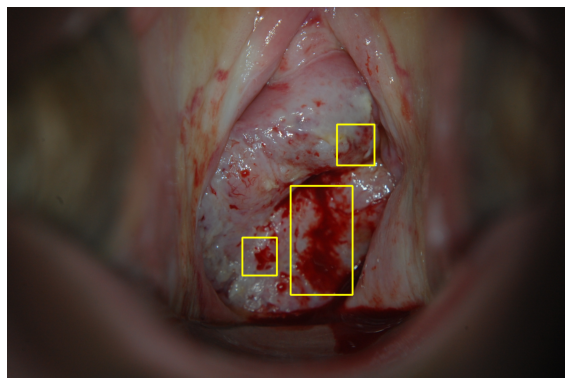

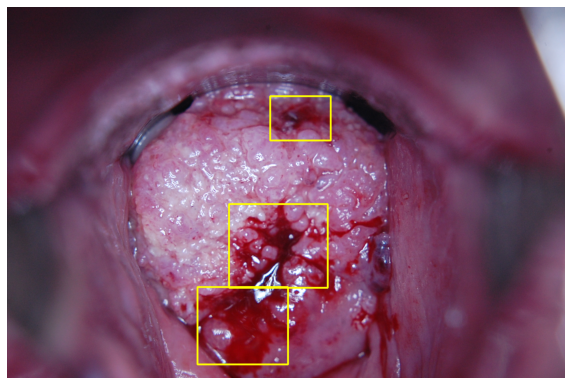

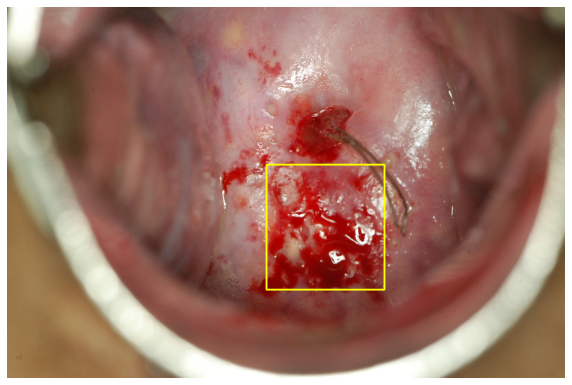

In [10]:
visualize_GT_bbox(df, 3, root) #

In [20]:
dataset_name = 'train2017'
datasetname_path = './datasets/%s/%s'%(foldername,dataset_name) # './datasets/Erosion2/val2017'
filecopy_maketxt(df, dataset_name, datasetname_path, test_ratio=0.2)
txt2json_save(foldername, dataset_name, 'detection')

dataset_name = 'val2017'
datasetname_path = './datasets/%s/%s'%(foldername,dataset_name) # './datasets/Erosion2/val2017'
filecopy_maketxt(df, dataset_name, datasetname_path, test_ratio=0.2)
txt2json_save(foldername, dataset_name, 'detection')

dataset =  train2017
0 / 419
1 / 419
2 / 419
3 / 419
4 / 419
5 / 419
6 / 419
7 / 419
8 / 419
9 / 419
10 / 419
11 / 419
12 / 419
13 / 419
14 / 419
15 / 419
16 / 419
17 / 419
18 / 419
19 / 419
20 / 419
21 / 419
22 / 419
23 / 419
24 / 419
25 / 419
26 / 419
27 / 419
28 / 419
29 / 419
30 / 419
31 / 419
32 / 419
33 / 419
34 / 419
35 / 419
36 / 419
37 / 419
38 / 419
39 / 419
40 / 419
41 / 419
42 / 419
43 / 419
44 / 419
45 / 419
46 / 419
47 / 419
48 / 419
49 / 419
50 / 419
51 / 419
52 / 419
53 / 419
54 / 419
55 / 419
56 / 419
57 / 419
58 / 419
59 / 419
60 / 419
61 / 419
62 / 419
63 / 419
64 / 419
65 / 419
66 / 419
67 / 419
68 / 419
69 / 419
70 / 419
71 / 419
72 / 419
73 / 419
74 / 419
75 / 419
76 / 419
77 / 419
78 / 419
79 / 419
80 / 419
81 / 419
82 / 419
83 / 419
84 / 419
85 / 419
86 / 419
87 / 419
88 / 419
89 / 419
90 / 419
91 / 419
92 / 419
93 / 419
94 / 419
95 / 419
96 / 419
97 / 419
98 / 419
99 / 419
100 / 419
101 / 419
102 / 419
103 / 419
104 / 419
105 / 419
106 / 419
107 / 419
108 / 419

0

# For classification task

##### 파일 수정 필요
1. ./yolox/data/datasets/coco.py
- "COCO" -> "NP" (61번 줄)
2. ./yolox/data/datasets/coco_classes.py 
- COCO_CLASSES =("negative","positive")
3. ./yolox/exp/yolox_base.py 
- self.num_classes = 2

In [ ]:
# 학습시킬 annotation json 만들기 위함
# 원본이미지 -> train2017, val2017 에 수기 분류 되어있는 상태라고 가정

# box annotation txt 파일 얻기(--path 에 annotation 얻고자하는 이미지 들어있는 폴더명 입력)
# 결과 ./YOLOX_outputs/yolox_x/vis_res/2022_04_27_07_12_27/result.txt 저장됨
# 저장된 형식 ./datasets/NP/val2017/5827746_3_P0.jpg,356.2274,12.861755,1170.963,939.6619

!python tools/ForGetAnnotation.py image -n yolox-x -c ./YOLOX_outputs/yolox_x_20220227/best_ckpt.pth --path ./datasets/NP/val2017/ --conf 0.25 --nms 0.45 --tsize 640 --expn np_annotation

In [ ]:
# result.txt -> train.txt, val.txt 로 "수기로" 분류 해야함.
# 저장 위치 ./datasets/NP/train.txt
# 저장 위치 ./datasets/NP/val.txt

In [ ]:
foldername = 'NP' # 저장할 폴더명

dataset_name = 'train2017'
datasetname_path = './datasets/%s/%s'%(foldername,dataset_name) # './datasets/NP/val2017'
txt2json_save(foldername, dataset_name, 'classification')

dataset_name = 'val2017'
datasetname_path = './datasets/%s/%s'%(foldername,dataset_name) # './datasets/NP/val2017'
txt2json_save(foldername, dataset_name, 'classification')